In [1]:
#our necessary imports
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt


In [2]:
random.seed(100)

#compilation of team defensive ratings
team_def_ratings = {
        'OKC': 106.6,
        'ORL': 109.1,
        'LAC': 109.4,
        'BOS': 110.1,
        'HOU': 110.3,
        'MIN': 110.8,
        'GSW': 111.0,
        'CLE': 111.8,
        'MIA': 112.0,
        'DET': 112.5,
        'MEM': 112.6,
        'MIL': 112.7,
        'NYK': 113.3,
        'IND': 113.3,
        'TOR': 113.6,
        'POR': 113.7,
        'LAL': 113.8,
        'CHI': 114.8,
        'ATL': 115.7,
        'BKN': 114.8,
        'DAL': 115.0,
        'DEN': 115.1,
        'SAC': 115.3,
        'BKN': 115.4,
        'CHA': 115.7,
        'SAS': 116.3,
        'PHI': 117.3,
        'PHO': 117.7,
        'WAS': 118.0,
        'NOP': 119.1,
        'UTA': 119.4
    }

In [3]:
tyrese_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/TyreseSznStats.csv") 
shai_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/ShaiSznStats.csv")  
siakam_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/SiakamSznStats.csv")  
jdub_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/JalenWilliamsSznStats.csv")  
nesmith_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/NesmithSznStats.csv")  
nemhard_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/NemhardSznStats.csv")  
hartenstein_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/iHartSznStats.csv") 
turner_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/TurnerSznStats.csv") 
chet_df = pd.read_csv("/Users/visve/Downloads/CS275 Project/Datasets/ChetSznStats.csv")

In [4]:
def drtg_adjustment_no_pos(avg_drtg, target_drtg):
    diff = target_drtg - avg_drtg  # Positive = easier defense
    return min(max(1 + (diff * 0.004), 0.85), 1.15)  # 0.4% per point

In [5]:
def hybrid_hmm_prediction(player_df, team_def_ratings, target_opponent, player_name):

    print(f"HYBRID HMM PREDICTION: {player_name} vs {target_opponent}")
    
    #get the relevant columns, drop missing data
    stat_cols = ['Points', 'Assists', 'Rebounds', 'Steals', 'Blocks', 'Turnovers']
    clean_df = player_df[stat_cols].dropna()
    
    # Check if we have enough data (shouldnt be the case however)
    if len(clean_df) < 10:
        print("Not enough data for HMM (need â‰¥10 games). Using last 5 game average.")
        return clean_df.tail(5).mean().to_dict()
    
    # Standardize data
    scaler = StandardScaler()
    X = scaler.fit_transform(clean_df.values)
    
    #HMM model 
    print("\nHMM Training Diagnostics:")
    model = hmm.GaussianHMM(
        n_components=3,
        covariance_type='diag',
        n_iter=1000,
        tol=1e-6,          
        random_state=100,
        verbose=True        
    )
    
    # Train HMM model and print log likelihood history
    try:
        model.fit(X)
        print(f"Converged after {model.monitor_.iter} iterations")
        print(f"Final Log Likelihood: {model.monitor_.history[-1]:.2f}")

        plt.figure(figsize=(6, 4))
        plt.plot(model.monitor_.history, color='darkred', lw=2)
        plt.xlabel("Iteration")
        plt.ylabel("Log Likelihood")
        plt.title(f"HMM Convergence ({player_name} Game Log)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # If model doesn't converge, catch it and use the last 5 games average
    except Exception as e:
        print(f"HMM Failed to Converge: {str(e)}")
        print("Will now use last 5 games weighted average.")

        #built-in exponential weighted moving average from pandas
        hmm_prediction = clean_df.ewm(span=5).mean().iloc[-1].values
    
    #Predict next state using the last 5 games
    recent_games = clean_df.tail(5)
    X_recent = scaler.transform(recent_games.values)
    
    #viterbi to find most likely state sequence
    try:
        log_probability, state_sequence = model.decode(X_recent, algorithm="viterbi")
        current_state = state_sequence[-1]
    
    #if decoding doesnt work, use the last state
    except:
        state_probs = model.predict_proba(X_recent)
        current_state = np.argmax(state_probs[-1])
    
    # Predict the next state using the HMM model
    hmm_prediction = scaler.inverse_transform([model.means_[current_state]])[0]
    hmm_dict = {}

    #predicted values back to the original data scale
    for i in range(len(stat_cols)):
        hmm_dict[stat_cols[i]] = hmm_prediction[i]
    
    player_df_with_drtg = player_df.copy()

    #the defensive adjustment, uses opponent defensive rating
    player_df_with_drtg['Opponent_DEF_RTG'] = player_df_with_drtg['Opponent'].map(team_def_ratings)
    player_df_with_drtg = player_df_with_drtg.dropna(subset=['Opponent_DEF_RTG'])
    
    #get the target opponent's DRTG
    target_drtg = team_def_ratings[target_opponent]
    avg_drtg = player_df_with_drtg['Opponent_DEF_RTG'].mean()
    
    # use linear adjustment function from earlier to calculate adjustment factor
    def_factor = drtg_adjustment_no_pos(avg_drtg, target_drtg)
    
    #test to see if defensive rating is being applied
    print(f"\nDefense Adjustment:")
    print(f"  Avg DRTG Faced: {avg_drtg:.1f}")
    print(f"  Target DRTG: {target_drtg:.1f}")
    print(f"  Adjustment Factor: {def_factor:.3f}")
    
    #adjust offensive stats more, since more affected by better defense
    final_prediction = hmm_dict.copy()
    for stat in ['Points', 'Assists']:  
        final_prediction[stat] *= def_factor
    
    # Round outputs
    for k, v in final_prediction.items():
        final_prediction[k] = int(round(v))
    
    # Print final prediction
    print(f"\nFinal Prediction:")
    for stat, val in final_prediction.items():
        print(f"  {stat}: {val}")
    
    return final_prediction


In [6]:

def traditional_hmm_no_drtg(player_df, target_opponent, player_name):
   
    print(f"\nTRADITIONAL HMM: {player_name} (No DRTG)")
    
    #get the relevant columns, drop missing data
    stat_cols = ['Points', 'Assists', 'Rebounds', 'Steals', 'Blocks', 'Turnovers']
    clean_df = player_df[stat_cols].dropna()
    
    # standard scaler
    scaler = StandardScaler()
    X = scaler.fit_transform(clean_df.values)

    #HMM model
    model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000, random_state=100)
    model.fit(X)
    
    # Predict next game using the last 5 games
    recent_games = clean_df.tail(5)
    X_recent = scaler.transform(recent_games.values)
    
    #viterbi algorithm to find most likely state sequence
    try:
        log_probability, state_sequence = model.decode(X_recent, algorithm="viterbi")
        current_state = state_sequence[-1]
        next_state = np.argmax(model.transmat_[current_state])

    # If decoding doesn't work, use the last state
    except:
        state_probs = model.predict(X_recent)
        current_state = state_probs[-1]
        next_state = current_state
    
    # Predict the next state usinghe HMM model
    prediction = scaler.inverse_transform([model.means_[next_state]])[0]
    
    #round output, and print results
    print(f"Traditional HMM Prediction:")
    result = {}

    for i in range(len(stat_cols)):
        stat = stat_cols[i]
        value = prediction[i]
        result[stat] = value
        print(f"  {stat}: {int(round(value))}")
    
    return result


In [7]:

# Comparison function
def compare_all_approaches(player_df, team_def_ratings, target_opponent, player_name):
   
    print(f"\nCOMPARISON: {player_name} vs {target_opponent}")
    
    #Hybrid HMM
    hybrid_result = hybrid_hmm_prediction(player_df, team_def_ratings, target_opponent, player_name)
    
    #Traditional HMM
    traditional_result = traditional_hmm_no_drtg(player_df, target_opponent, player_name)
    
    # simple recent average method with defense adjustment after
    stat_cols = ['Points', 'Assists', 'Rebounds', 'Steals', 'Blocks', 'Turnovers']
    recent_avg = player_df[stat_cols].tail(10).mean()
    
    player_df_drtg = player_df.copy()
    player_df_drtg['Opponent_DEF_RTG'] = player_df_drtg['Opponent'].map(team_def_ratings)
    player_df_drtg = player_df_drtg.dropna(subset=['Opponent_DEF_RTG'])
    
    # Get the target opponent's DRTG
    target_drtg = team_def_ratings[target_opponent]
    avg_drtg = player_df_drtg['Opponent_DEF_RTG'].mean()
    def_factor = avg_drtg / target_drtg
    
    # Apply defense adjustment to recent average
    simple_result = recent_avg.copy()
    for stat in ['Points', 'Assists']:
        simple_result[stat] *= def_factor
    
    #final comparisons
    print(f"\nFINAL COMPARISON:")
    print(f"{'Stat':<10} {'Hybrid':<8} {'Traditional':<11} {'Simple':<8} {'Range'}")
    
    for stat in stat_cols:
        # Round values
        hybrid_val = int(round(hybrid_result[stat]))
        trad_val = int(round(traditional_result[stat]))
        simple_val = int(round(simple_result[stat]))
        
        #range to see how different the method outputs are
        values = [hybrid_val, trad_val, simple_val]
        range_val = max(values) - min(values)
        
        # Print results and round to nearest integer
        print(f"{stat:<10} {hybrid_val:<8} {trad_val:<11} {simple_val:<8} {range_val}")
    
    return hybrid_result, traditional_result, simple_result.to_dict()


COMPARISON: Tyrese Haliburton vs OKC
HYBRID HMM PREDICTION: Tyrese Haliburton vs OKC

HMM Training Diagnostics:
Converged after 30 iterations
Final Log Likelihood: -508.22


         1    -836.85456585             +nan
         2    -779.36438471     +57.49018113
         3    -775.20723737      +4.15714735
         4    -769.18549441      +6.02174296
         5    -763.93611650      +5.24937791
         6    -761.82493484      +2.11118166
         7    -760.41009311      +1.41484173
         8    -759.11091695      +1.29917615
         9    -757.90957304      +1.20134391
        10    -756.53332407      +1.37624897
        11    -752.04569142      +4.48763265
        12    -722.65926923     +29.38642219
        13    -669.17548490     +53.48378433
        14    -639.05679252     +30.11869238
        15    -615.46281231     +23.59398021
        16    -602.66752150     +12.79529081
        17    -599.19315689      +3.47436461
        18    -597.83553320      +1.35762369
        19    -595.54389029      +2.29164292
        20    -586.40114725      +9.14274304
        21    -578.94827208      +7.45287517
        22    -572.42525824      +6.52301384
        23

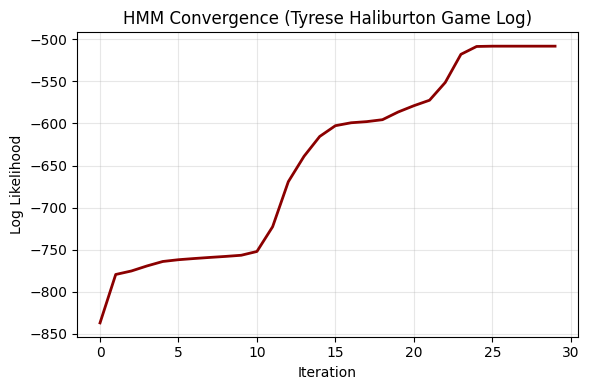


Defense Adjustment:
  Avg DRTG Faced: 113.2
  Target DRTG: 106.6
  Adjustment Factor: 0.974

Final Prediction:
  Points: 18
  Assists: 9
  Rebounds: 4
  Steals: 1
  Blocks: 0
  Turnovers: 2

TRADITIONAL HMM: Tyrese Haliburton (No DRTG)
Traditional HMM Prediction:
  Points: 18
  Assists: 9
  Rebounds: 4
  Steals: 1
  Blocks: 0
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     18       18          18       0
Assists    9        9           8        1
Rebounds   4        4           6        2
Steals     1        1           2        1
Blocks     0        0           1        1
Turnovers  2        2           2        0


In [8]:
# Test the hybrid approach
hybrid_result, traditional_result, simple_result = compare_all_approaches(
    tyrese_df, team_def_ratings, "OKC", "Tyrese Haliburton"
)

         1    -858.08465471             +nan
         2    -822.09837785     +35.98627687
         3    -818.01368977      +4.08468807
         4    -815.15828991      +2.85539986
         5    -813.20602999      +1.95225993
         6    -811.87699987      +1.32903012
         7    -810.92386262      +0.95313725
         8    -810.28336337      +0.64049925
         9    -809.86804264      +0.41532073
        10    -809.61254711      +0.25549553
        11    -809.45851314      +0.15403397
        12    -809.35243733      +0.10607580
        13    -809.26678172      +0.08565562
        14    -809.18964798      +0.07713374
        15    -809.11442244      +0.07522555
        16    -809.03557665      +0.07884578
        17    -808.94792825      +0.08764840
        18    -808.84954803      +0.09838023
        19    -808.74728208      +0.10226595
        20    -808.65584642      +0.09143566
        21    -808.58573537      +0.07011105
        22    -808.53654671      +0.04918867
        23


COMPARISON: Shai-Gilgeous Alexander vs IND
HYBRID HMM PREDICTION: Shai-Gilgeous Alexander vs IND

HMM Training Diagnostics:
Converged after 65 iterations
Final Log Likelihood: -807.55


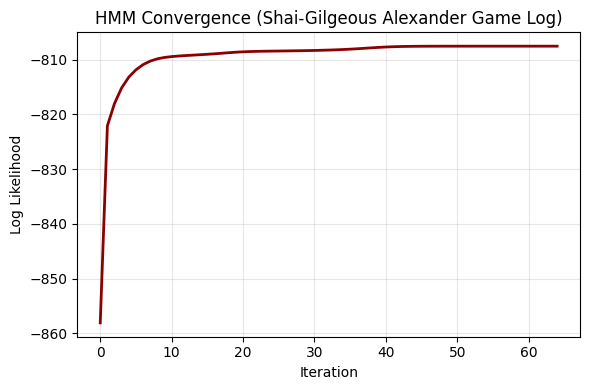


Defense Adjustment:
  Avg DRTG Faced: 113.6
  Target DRTG: 113.3
  Adjustment Factor: 0.999

Final Prediction:
  Points: 33
  Assists: 7
  Rebounds: 7
  Steals: 1
  Blocks: 1
  Turnovers: 3

TRADITIONAL HMM: Shai-Gilgeous Alexander (No DRTG)
Traditional HMM Prediction:
  Points: 31
  Assists: 7
  Rebounds: 4
  Steals: 2
  Blocks: 1
  Turnovers: 3

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     33       31          31       2
Assists    7        7           6        1
Rebounds   7        4           5        3
Steals     1        2           2        1
Blocks     1        1           1        0
Turnovers  3        3           4        1


In [9]:
hybrid_result1, traditional_result1, simple_result1 = compare_all_approaches(
    shai_df, team_def_ratings, "IND", "Shai-Gilgeous Alexander"
)


COMPARISON: Pascal Siakam vs OKC
HYBRID HMM PREDICTION: Pascal Siakam vs OKC

HMM Training Diagnostics:
Converged after 52 iterations
Final Log Likelihood: -535.72


         1    -902.85982279             +nan
         2    -824.41623384     +78.44358895
         3    -807.70066544     +16.71556840
         4    -737.79908517     +69.90158027
         5    -702.10962342     +35.68946175
         6    -681.03855589     +21.07106754
         7    -659.91892603     +21.11962986
         8    -628.63733282     +31.28159321
         9    -611.88514766     +16.75218515
        10    -608.44679852      +3.43834914
        11    -607.23084894      +1.21594958
        12    -606.87278948      +0.35805946
        13    -606.70419738      +0.16859210
        14    -606.62131997      +0.08287740
        15    -606.57495386      +0.04636612
        16    -606.54526342      +0.02969044
        17    -606.52456044      +0.02070298
        18    -606.50984994      +0.01471050
        19    -606.49973860      +0.01011134
        20    -606.49314591      +0.00659268
        21    -606.48905379      +0.00409212
        22    -606.48660571      +0.00244808
        23

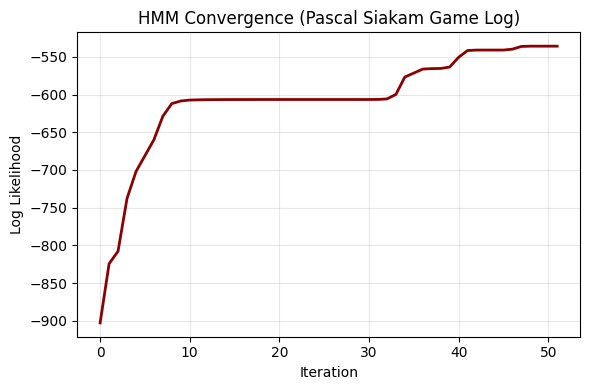


Defense Adjustment:
  Avg DRTG Faced: 113.3
  Target DRTG: 106.6
  Adjustment Factor: 0.973

Final Prediction:
  Points: 21
  Assists: 3
  Rebounds: 8
  Steals: 1
  Blocks: 1
  Turnovers: 1

TRADITIONAL HMM: Pascal Siakam (No DRTG)
Traditional HMM Prediction:
  Points: 20
  Assists: 3
  Rebounds: 7
  Steals: 1
  Blocks: 0
  Turnovers: 1

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     21       20          23       3
Assists    3        3           4        1
Rebounds   8        7           7        1
Steals     1        1           2        1
Blocks     1        0           1        1
Turnovers  1        1           2        1


In [10]:
hybrid_result2, traditional_result2, simple_resul2 = compare_all_approaches(
    siakam_df, team_def_ratings, "OKC", "Pascal Siakam"
)

         1    -789.78342321             +nan
         2    -761.25933203     +28.52409119
         3    -756.79135975      +4.46797228
         4    -753.68784045      +3.10351930
         5    -749.98926069      +3.69857975
         6    -746.17319238      +3.81606832
         7    -743.13770756      +3.03548482
         8    -740.69236236      +2.44534520
         9    -739.82135603      +0.87100633
        10    -739.34395929      +0.47739674
        11    -738.91365260      +0.43030669
        12    -738.57682005      +0.33683255
        13    -738.37792137      +0.19889868
        14    -738.23623794      +0.14168343
        15    -738.11895737      +0.11728057
        16    -738.02238328      +0.09657409
        17    -737.94559296      +0.07679033
        18    -737.88634071      +0.05925225
        19    -737.84131768      +0.04502303
        20    -737.80709524      +0.03422244
        21    -737.78078227      +0.02631297
        22    -737.76021444      +0.02056783
        23


COMPARISON: Jalen Williams vs IND
HYBRID HMM PREDICTION: Jalen Williams vs IND

HMM Training Diagnostics:
Converged after 69 iterations
Final Log Likelihood: -566.40


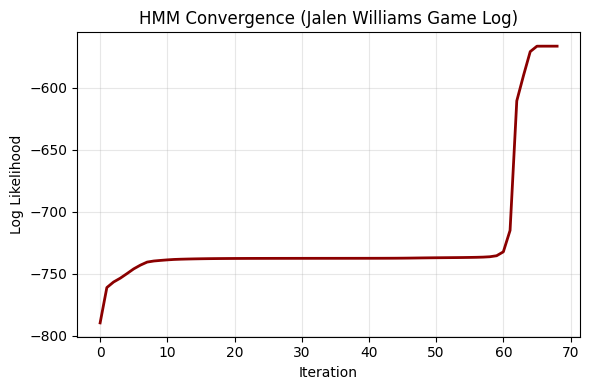


Defense Adjustment:
  Avg DRTG Faced: 113.7
  Target DRTG: 113.3
  Adjustment Factor: 0.998

Final Prediction:
  Points: 21
  Assists: 5
  Rebounds: 5
  Steals: 1
  Blocks: 0
  Turnovers: 2

TRADITIONAL HMM: Jalen Williams (No DRTG)
Traditional HMM Prediction:
  Points: 21
  Assists: 4
  Rebounds: 5
  Steals: 1
  Blocks: 0
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     21       21          24       3
Assists    5        4           4        1
Rebounds   5        5           6        1
Steals     1        1           1        0
Blocks     0        0           0        0
Turnovers  2        2           2        0


In [11]:
hybrid_result3, traditional_result3, simple_result3 = compare_all_approaches(
    jdub_df, team_def_ratings, "IND", "Jalen Williams"
)


COMPARISON: Aaron Nesmith vs OKC
HYBRID HMM PREDICTION: Aaron Nesmith vs OKC

HMM Training Diagnostics:


         1    -576.14182763             +nan
         2    -547.84331460     +28.29851303
         3    -542.28913548      +5.55417913
         4    -539.57262654      +2.71650894
         5    -538.74518502      +0.82744152
         6    -538.11071267      +0.63447235
         7    -537.39594266      +0.71477001
         8    -536.60686600      +0.78907666
         9    -535.89300367      +0.71386233
        10    -535.26154508      +0.63145859
        11    -534.72189557      +0.53964950
        12    -534.36261133      +0.35928425
        13    -534.15185000      +0.21076133
        14    -533.97622216      +0.17562783
        15    -533.68210959      +0.29411258
        16    -532.91217687      +0.76993272
        17    -531.66660671      +1.24557016
        18    -530.98318505      +0.68342166
        19    -530.62070983      +0.36247522
        20    -530.29635025      +0.32435957
        21    -529.96243987      +0.33391038
        22    -529.65845519      +0.30398468
        23

Converged after 75 iterations
Final Log Likelihood: -529.20


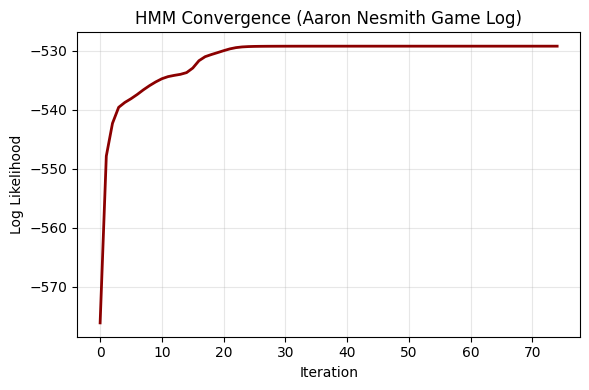


Defense Adjustment:
  Avg DRTG Faced: 113.1
  Target DRTG: 106.6
  Adjustment Factor: 0.974

Final Prediction:
  Points: 8
  Assists: 1
  Rebounds: 3
  Steals: 1
  Blocks: 0
  Turnovers: 1

TRADITIONAL HMM: Aaron Nesmith (No DRTG)
Traditional HMM Prediction:
  Points: 9
  Assists: 1
  Rebounds: 3
  Steals: 1
  Blocks: 0
  Turnovers: 1

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     8        9           11       3
Assists    1        1           1        0
Rebounds   3        3           5        2
Steals     1        1           1        0
Blocks     0        0           0        0
Turnovers  1        1           1        0


In [12]:
hybrid4, traditional4, simple4 = compare_all_approaches(
    nesmith_df, team_def_ratings, "OKC", "Aaron Nesmith"
)



COMPARISON: Andrew Nembhard vs OKC
HYBRID HMM PREDICTION: Andrew Nembhard vs OKC

HMM Training Diagnostics:
Converged after 62 iterations
Final Log Likelihood: -376.16


         1    -763.03638276             +nan
         2    -631.41543849    +131.62094427
         3    -407.84576638    +223.56967211
         4    -404.90006504      +2.94570134
         5    -403.58551842      +1.31454662
         6    -403.09272684      +0.49279158
         7    -402.95365260      +0.13907424
         8    -402.90905112      +0.04460148
         9    -402.88874280      +0.02030831
        10    -402.87630585      +0.01243696
        11    -402.86717514      +0.00913070
        12    -402.85972036      +0.00745479
        13    -402.85320739      +0.00651296
        14    -402.84723499      +0.00597241
        15    -402.84154393      +0.00569106
        16    -402.83593914      +0.00560479
        17    -402.83025132      +0.00568782
        18    -402.82431323      +0.00593808
        19    -402.81794050      +0.00637274
        20    -402.81091095      +0.00702955
        21    -402.80293759      +0.00797336
        22    -402.79362802      +0.00930957
        23

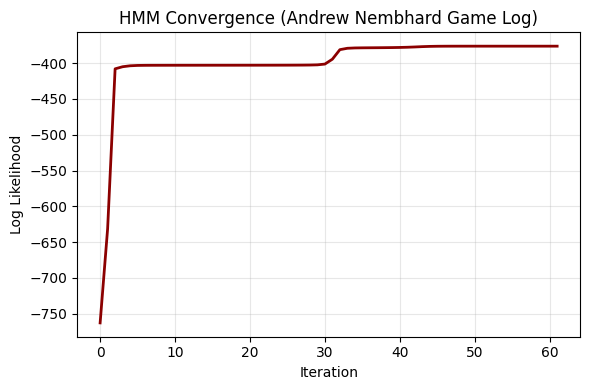


Defense Adjustment:
  Avg DRTG Faced: 113.1
  Target DRTG: 106.6
  Adjustment Factor: 0.974

Final Prediction:
  Points: 11
  Assists: 5
  Rebounds: 3
  Steals: 1
  Blocks: 0
  Turnovers: 2

TRADITIONAL HMM: Andrew Nembhard (No DRTG)
Traditional HMM Prediction:
  Points: 11
  Assists: 5
  Rebounds: 3
  Steals: 1
  Blocks: 0
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     11       11          11       0
Assists    5        5           4        1
Rebounds   3        3           3        0
Steals     1        1           2        1
Blocks     0        0           0        0
Turnovers  2        2           2        0


In [13]:
hybrid6, traditional6, simple6 = compare_all_approaches(
    nemhard_df, team_def_ratings, "OKC", "Andrew Nembhard"
)


COMPARISON: Isaiah Hartenstein vs IND
HYBRID HMM PREDICTION: Isaiah Hartenstein vs IND

HMM Training Diagnostics:
Converged after 59 iterations
Final Log Likelihood: -608.55


         1    -686.88949569             +nan
         2    -627.83851331     +59.05098237
         3    -619.88634141      +7.95217190
         4    -616.41383696      +3.47250445
         5    -614.24266622      +2.17117074
         6    -612.98360824      +1.25905799
         7    -612.28392652      +0.69968172
         8    -611.88741204      +0.39651448
         9    -611.67160030      +0.21581174
        10    -611.55228480      +0.11931550
        11    -611.47554675      +0.07673805
        12    -611.41571098      +0.05983577
        13    -611.36282277      +0.05288822
        14    -611.31344966      +0.04937311
        15    -611.26629479      +0.04715487
        16    -611.22033283      +0.04596195
        17    -611.17388315      +0.04644968
        18    -611.12395924      +0.04992391
        19    -611.06573570      +0.05822354
        20    -610.99222919      +0.07350651
        21    -610.89448874      +0.09774045
        22    -610.76268601      +0.13180273
        23

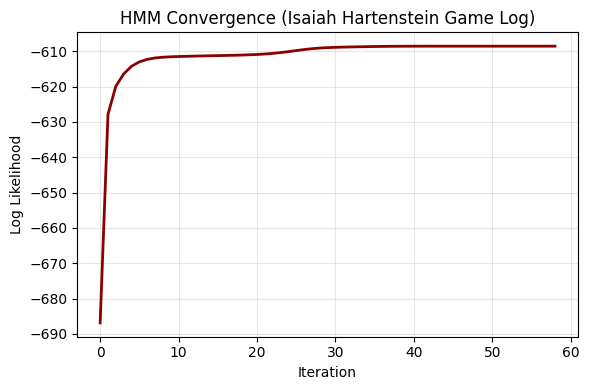


Defense Adjustment:
  Avg DRTG Faced: 113.5
  Target DRTG: 113.3
  Adjustment Factor: 0.999

Final Prediction:
  Points: 8
  Assists: 2
  Rebounds: 6
  Steals: 1
  Blocks: 0
  Turnovers: 1

TRADITIONAL HMM: Isaiah Hartenstein (No DRTG)
Traditional HMM Prediction:
  Points: 8
  Assists: 2
  Rebounds: 6
  Steals: 1
  Blocks: 0
  Turnovers: 1

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     8        8           5        3
Assists    2        2           2        0
Rebounds   6        6           6        0
Steals     1        1           1        0
Blocks     0        0           1        1
Turnovers  1        1           1        0


In [14]:
hybrid7, traditional7, simple7 = compare_all_approaches(
    hartenstein_df, team_def_ratings, "IND", "Isaiah Hartenstein"
)



COMPARISON: Myles Turner vs OKC
HYBRID HMM PREDICTION: Myles Turner vs OKC

HMM Training Diagnostics:
Converged after 103 iterations
Final Log Likelihood: -768.34


         1    -820.10108669             +nan
         2    -782.73404164     +37.36704506
         3    -774.60918392      +8.12485772
         4    -771.37266981      +3.23651411
         5    -769.81913959      +1.55353022
         6    -769.14563648      +0.67350311
         7    -768.86879824      +0.27683824
         8    -768.74499530      +0.12380294
         9    -768.67986762      +0.06512768
        10    -768.64026661      +0.03960101
        11    -768.61332277      +0.02694384
        12    -768.59335384      +0.01996894
        13    -768.57760568      +0.01574815
        14    -768.56464329      +0.01296240
        15    -768.55366476      +0.01097852
        16    -768.54418669      +0.00947807
        17    -768.53589289      +0.00829380
        18    -768.52855920      +0.00733369
        19    -768.52201495      +0.00654425
        20    -768.51612252      +0.00589242
        21    -768.51076617      +0.00535635
        22    -768.50584549      +0.00492068
        23

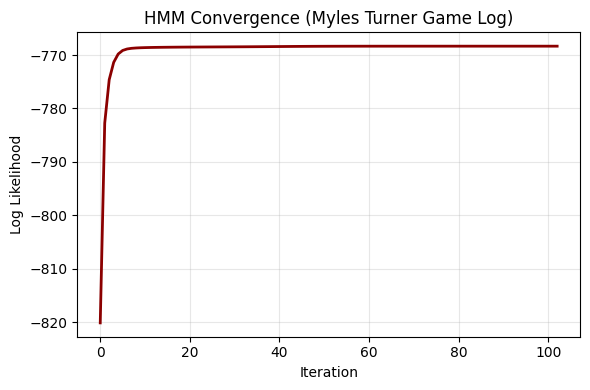


Defense Adjustment:
  Avg DRTG Faced: 113.1
  Target DRTG: 106.6
  Adjustment Factor: 0.974

Final Prediction:
  Points: 9
  Assists: 1
  Rebounds: 4
  Steals: 0
  Blocks: 1
  Turnovers: 2

TRADITIONAL HMM: Myles Turner (No DRTG)
Traditional HMM Prediction:
  Points: 17
  Assists: 1
  Rebounds: 8
  Steals: 0
  Blocks: 3
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     9        17          12       8
Assists    1        1           2        1
Rebounds   4        8           4        4
Steals     0        0           0        0
Blocks     1        3           2        2
Turnovers  2        2           2        0


In [15]:
hybrid8, traditional8, simple8 = compare_all_approaches(
    turner_df, team_def_ratings, "OKC", "Myles Turner"
)


COMPARISON: Chet Holmgren vs IND
HYBRID HMM PREDICTION: Chet Holmgren vs IND

HMM Training Diagnostics:
Converged after 11 iterations
Final Log Likelihood: -341.15


         1    -467.73434102             +nan
         2    -432.64511807     +35.08922295
         3    -428.11257649      +4.53254158
         4    -423.60169563      +4.51088086
         5    -413.58223053     +10.01946510
         6    -369.85470104     +43.72752949
         7    -341.18559176     +28.66910928
         8    -341.14997040      +0.03562136
         9    -341.14944915      +0.00052125
        10    -341.14944242      +0.00000673
        11    -341.14944231      +0.00000011


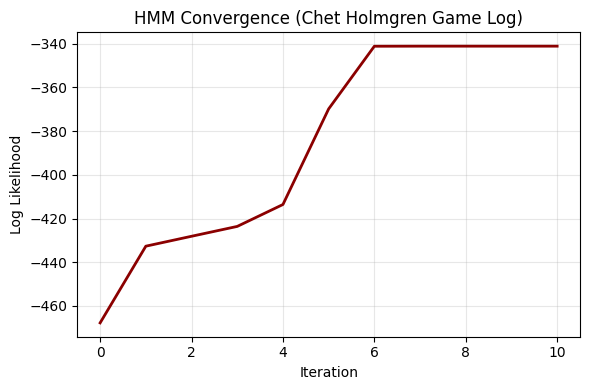


Defense Adjustment:
  Avg DRTG Faced: 113.5
  Target DRTG: 113.3
  Adjustment Factor: 0.999

Final Prediction:
  Points: 15
  Assists: 1
  Rebounds: 7
  Steals: 0
  Blocks: 1
  Turnovers: 2

TRADITIONAL HMM: Chet Holmgren (No DRTG)
Traditional HMM Prediction:
  Points: 15
  Assists: 1
  Rebounds: 7
  Steals: 0
  Blocks: 1
  Turnovers: 2

FINAL COMPARISON:
Stat       Hybrid   Traditional Simple   Range
Points     15       15          14       1
Assists    1        1           1        0
Rebounds   7        7           8        1
Steals     0        0           0        0
Blocks     1        1           1        0
Turnovers  2        2           2        0


In [16]:
hybrid9, traditional9, simple9 = compare_all_approaches(
    chet_df, team_def_ratings, "IND", "Chet Holmgren"
)